# 1. Camera Calibration

Our initial goal is to obtain a transformation matrix to map a 3D object to a 2D image and a set of coefficients representative of the distortion due to the optics and setting of the image capturing device. Let's import first the main libraries used for this project:


In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib qt

nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

'''
img = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(img)
'''

"\nimg = mpimg.imread('camera_cal/calibration1.jpg')\nplt.imshow(img)\n"

The camera calibration function receives a set of images from a source and uses cv2.calibrateCamera to obtain the calibration matrix and distortion coefficients

In [2]:
def camera_calibration(images, nx, ny):
    
    # Prepare object points in the format (0,0,0), (0,1,0),..., (8,8,0)
    objp =  np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x and y coordinates. z value is zero for all points

    # Arrays to store object and image points for all the images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane
    
    # Step through the list and search for chess corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if ret ==  True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display corners
            #img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #cv2.imshow('img', img)
            #cv2.waitKey(500)
    ret, mtx, dist, rvec, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist
    #cv2.destroyAllWindows()

mtx , dist = camera_calibration(images,nx,ny)

# 2. Distortion correction

The following procedure distort the image and apply color/gradient threshold to clearly identify the lane lines

In [3]:
def undistort_image(img, mtx, dist):
    #1. Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist

# 3. Color and gradient thresholds

In [9]:
def threshold_function(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2] # Takes the saturation channel from the image in HLS color space
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Convert rgb image to gray scale
    
    # Threshold over gradient: Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in the x direction
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(sobelx))
    
    #Threshold x gradient
    thresh_min = 10 
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx < thresh_max)] = 1
    
    # Threshold over color: Saturation channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min)&( s_channel < s_thresh_max)] = 1
    
    # Stack both channels to see their individual contributions as blue (saturation channel) and green (sobel x)
    color_binary = np.dstack((np.zeros_like(s_channel), sxbinary, s_binary ))*255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(sxbinary==1) | (s_binary==1)] = 1
    
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
    ax1.set_title('Stacked thresholds', fontsize=50)
    ax1.imshow(color_binary)

    ax2.set_title('Binary image combined thresholds', fontsize=50)
    ax2.imshow(combined_binary, cmap='gray')
    
    return combined_binary


# 4. Perspective transform

Based on previous modifications of the original image now we apply a perspective transform. Our goal is to see the real nature of the lanes as seen from the top down. Lanes should be parallel and clear on the final result

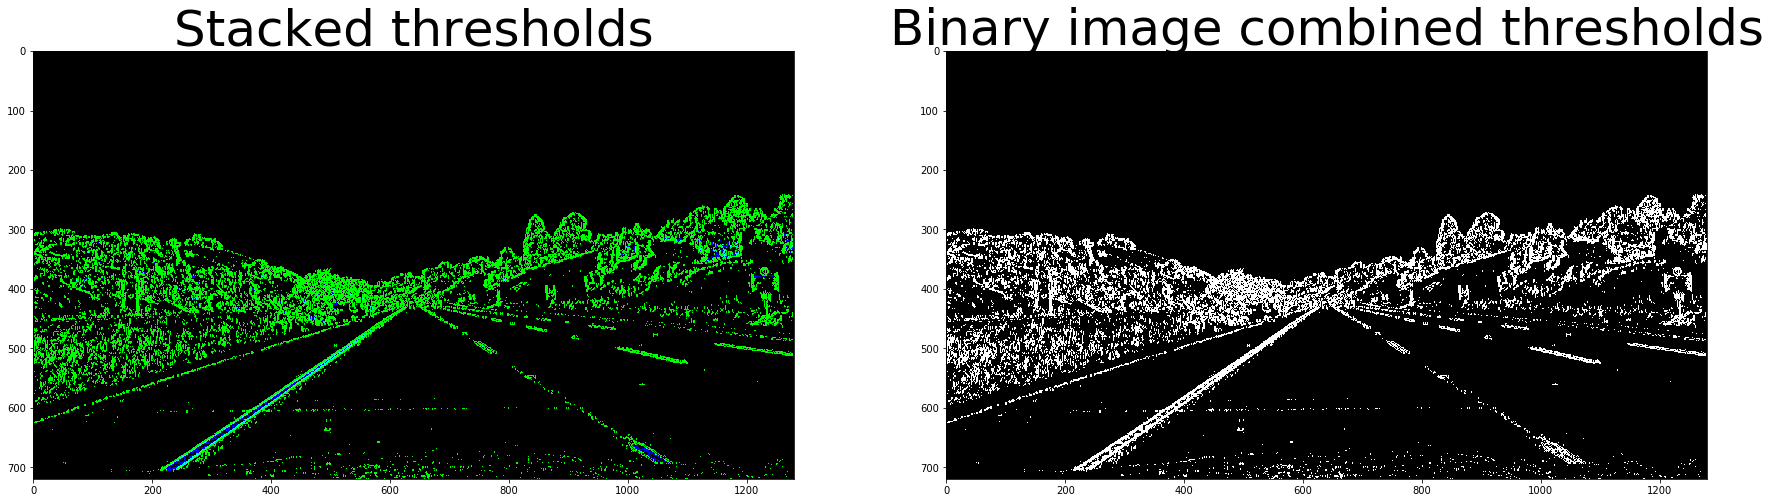

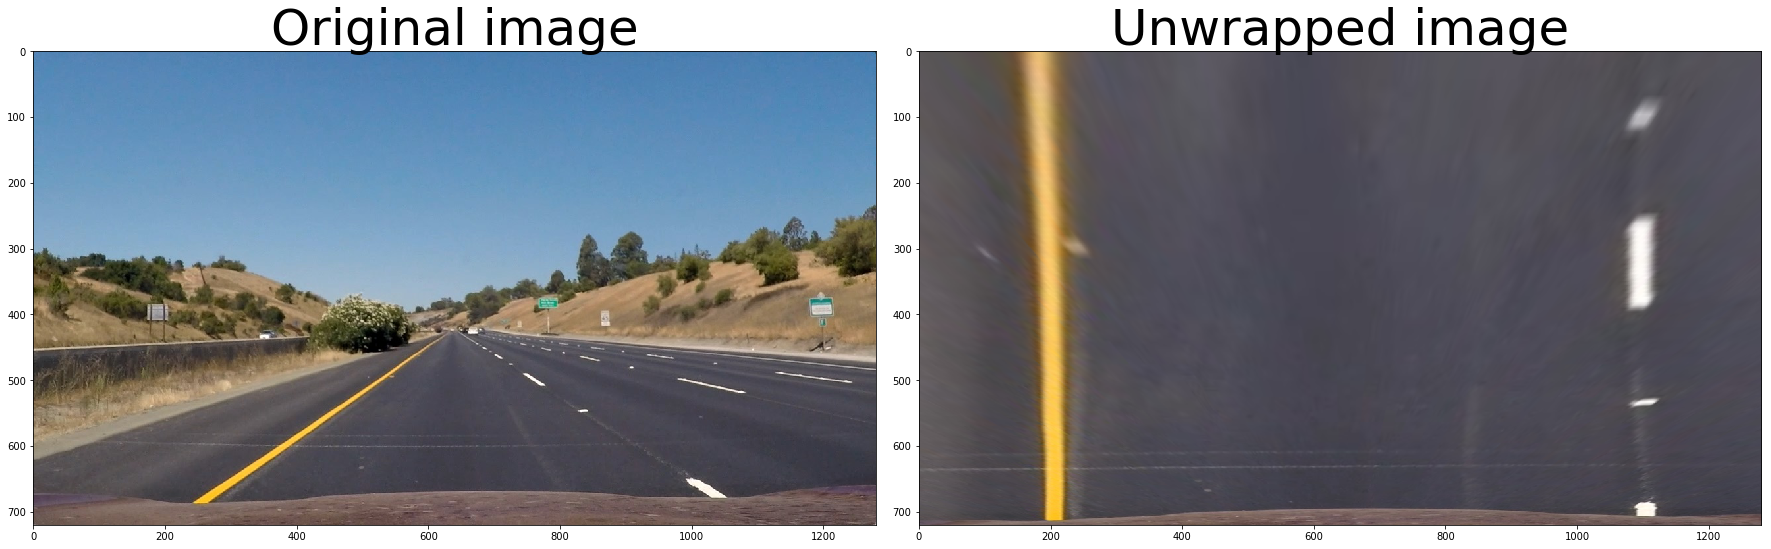

In [10]:
def unwarp_image(img,mtx,dist):
    
    M = None
    warped = None
    
    offset = 350
    # x and y image sizes
    img_size = (img.shape[1], img.shape[0])

    #b. Define four source points src=np.float32([[,],[,],[,],[,]])
    src = np.float32([[200,img_size[1]], [572,469], [716,469], [1100,img_size[1]]])

    #c. Define four destination points dst=np.float32([[,],[,],[,],[,]])
    #dst = np.float32([[offset,img_size[1]],[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]]])
    dst = np.float32([[200,img_size[1]],[200,0],[1100,0],[1100,img_size[1]]])
    #d. Get perspective transform M using the source and destination points
    M = cv2.getPerspectiveTransform(src, dst)

    #e. Warp the image captured by the camera using this transform to get an accurate depiction of the 2D image
    warped = cv2.warpPerspective(img, M,  img_size, flags=cv2.INTER_LINEAR)
        
    return warped, M

#images = glob.glob('test_images/test*.jpg')
images = ['test_images/straight_lines1.jpg']
for fname in images:
    img = mpimg.imread(fname)
    undist = undistort_image(img, mtx, dist)
    img_thresh = threshold_function(undist)
    
    top_down, perspective_M = unwarp_image(undist,mtx, dist)

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original image', fontsize=50)
    ax2.imshow(top_down, cmap='gray')
    ax2.set_title('Unwrapped image', fontsize= 50)
    plt.subplots_adjust(left = 0., right = 1, top=0.9, bottom = 0.)
